This is an attempt to predict Stock prices based on Stock prices of previous days. The stock market refers to the collection of markets and exchanges where regular activities of buying, selling, and issuance of shares of publicly-held companies take place.

This is a time series analysis and we will see simple eight ways to predict the Stock prices. The various models to be used are:

Average

Weighted Average

Moving Average

Moving Weighted Average

Linear Regression

Weighted Linear Regression

Lasso Regression

Moving Window Neural Network


In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import kagglehub
import os

In [59]:
path = kagglehub.dataset_download("atulanandjha/national-stock-exchange-time-series")

# Find the CSV file within the downloaded directory
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        file_path = os.path.join(path, filename)
        break

data = pd.read_csv(file_path, usecols=['Date', 'Close'], parse_dates=['Date'], index_col='Date')
data.head()

,Close
Date,
2015-01-01,1974.40
2015-01-02,2013.20
2015-01-05,1995.90
2015-01-06,1954.20
2015-01-07,1963.55


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2015-01-01 to 2015-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   248 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [61]:
data.shape

(248, 1)

In [62]:
data.loc['2015-01-07',:]

Close    1963.55
Name: 2015-01-07 00:00:00, dtype: float64

In [63]:
print("Min:",data.index.min())
print("Max:",data.index.max())

Min: 2015-01-01 00:00:00
Max: 2015-12-31 00:00:00


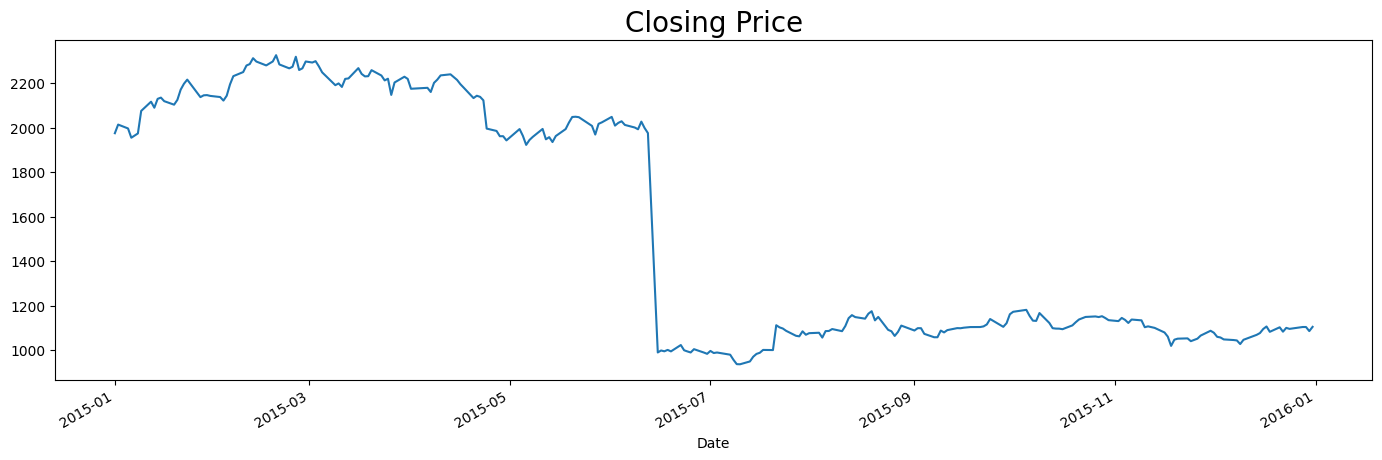

In [64]:
plt.figure(figsize=(17,5))
data.Close.plot()
plt.title("Closing Price",fontsize=20)
plt.show()

**Adjustment for split-up**

If we take this whole data, the prediction might not be as expected as there is a split in between!

We have to either drop the data or adjust the values before split. Since the split is 2 for 1, we can normalize the data prior to split by dividing them by 2. (Old shares are half that of today's share).

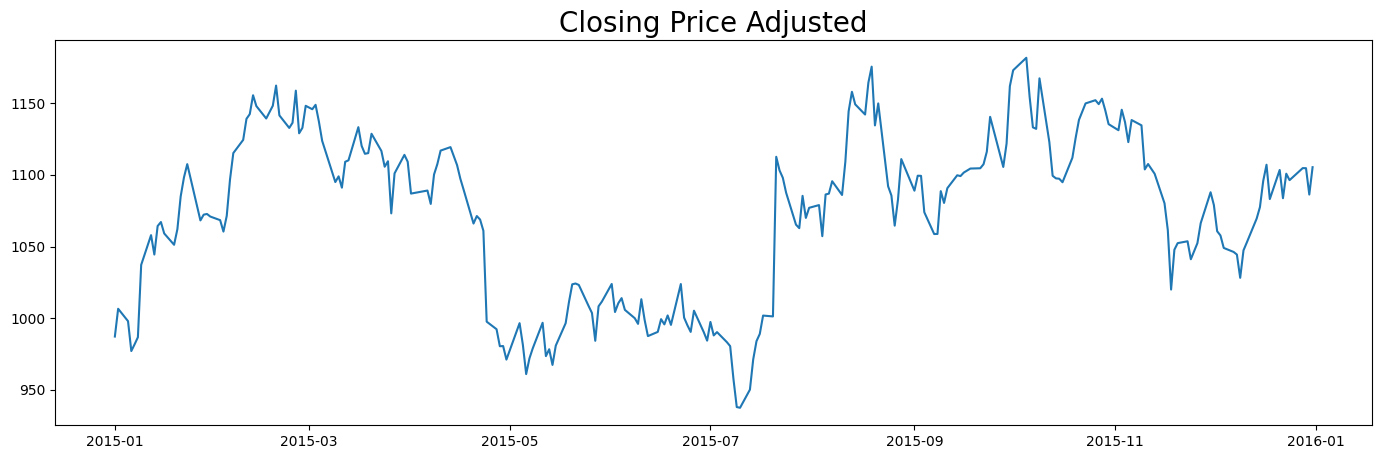

In [65]:
# The Split
plt.figure(figsize=(17,5))
stock_price = pd.concat([data.Close[:'2015-06-12']/2,data.Close['2015-06-15':]]) # adjustment
plt.plot(stock_price)
plt.title("Closing Price Adjusted",fontsize=20)
plt.show()

And now we have an adjusted time series of Infosys stock prices.

Lets now Predict the Stock price based on various methods.

We will predict the values on last 68 days in the series.
We will use Mean squared error as a metrics to calculate the error in our prediction.
We will compare the results of various methods at the end.

In [66]:
#helper function to plot the stock prediction
prev_values = stock_price.iloc[:180] #train
y_test = stock_price.iloc[180:] #test

def plot_pred(pred,title):
    plt.figure(figsize=(17,5))
    plt.plot(prev_values,label='Train')
    plt.plot(y_test,label='Actual')
    plt.plot(pred,label='Predicted')
    plt.ylabel("Stock prices")
    plt.title(title,fontsize=20)
    plt.legend()
    plt.show()

In [67]:
#Average of previous values
y_av = pd.Series(np.repeat(prev_values.mean(),68),index=y_test.index)
mse(y_av,y_test)

3173.6356476000856

In [68]:
np.sqrt(mse(y_av,y_test))

np.float64(56.33503037720035)

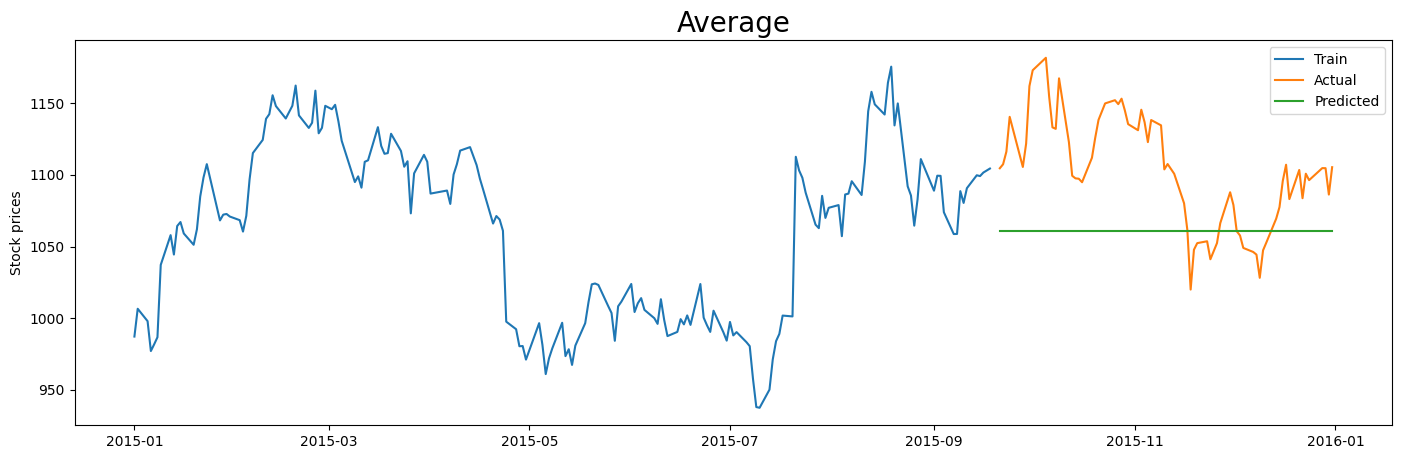

In [69]:
plot_pred(y_av,'Average')

2. **Weighted Mean**

We shall give more weightage to the data which are close to the last day in training data, while calculating the mean. The last day in the training set will get a weightage of 1(=180/180) and the first day will get a weightage of 1/180.

In [70]:
weight = np.array(range(0,180))/180
weighted_train_data =np.multiply(prev_values,weight)

# weighted average is the sum of this weighted train data by the sum of the weight

weighted_average = sum(weighted_train_data)/sum(weight)
y_wa = pd.Series(np.repeat(weighted_average,68),index=y_test.index)

print("MSE: " ,mse(y_wa,y_test))
print("RMSE: " ,np.sqrt(mse(y_wa,y_test)))

MSE:  3496.475652551586
RMSE:  59.1310041564625


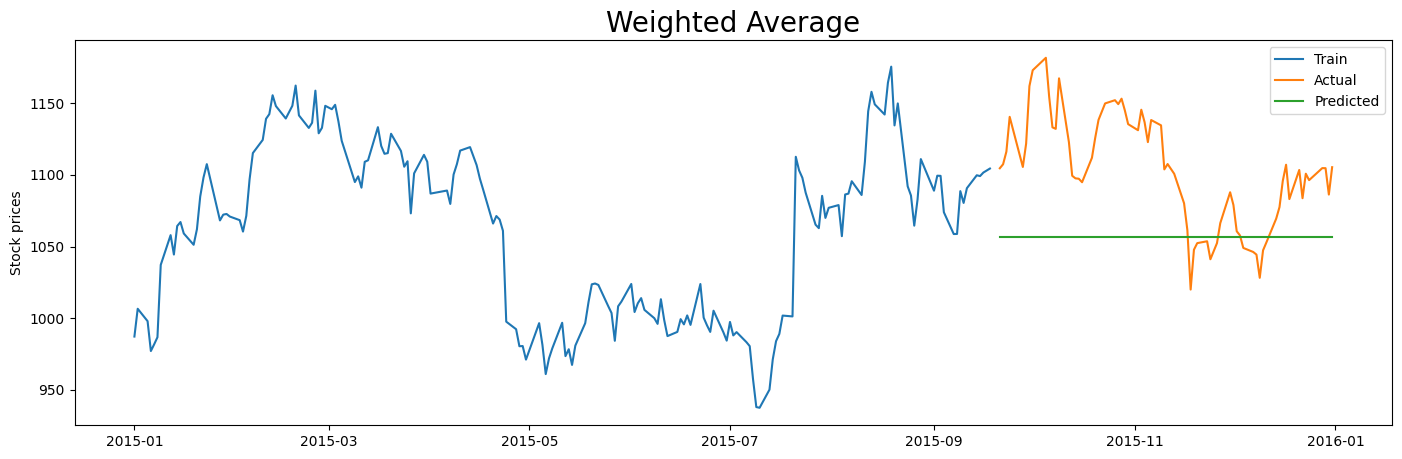

In [71]:
plot_pred(y_wa,'Weighted Average')

For the other methods we will predict the value of stock price on a day based on the values of stock prices of 80 days prior to it. So in our series we will not consider the first eight days (since there previous eighty days is not in the series).
We have to test the last 68 values. This would be based on the last 80 days stock prices of each day in the test data.
Since we have neglected first 80 and last 68 is our test set, the train dataset will be between 80 and 180 (100 days).

In [72]:
y_train = stock_price[80:180]
y_test = stock_price[180:]
print("y train:",y_train.shape,"\ny test:",y_test.shape)

y train: (100,) 
y test: (68,)


There are 100 days in training and 68 days in testing set. We will construct the features, that is the last 80 days stock for each date in the y_train and y_test. This would be our target variable.

In [73]:
X_train = pd.DataFrame([list(stock_price[i:i+80]) for i in range(100)],
                       columns=range(80,0,-1),index=y_train.index)
X_test = pd.DataFrame([list(stock_price[i:i+80]) for i in range(100,168)],
                       columns=range(80,0,-1),index=y_test.index)

X_train

,80,79,78,77,76,75,74,73,72,71,...,10,9,8,7,6,5,4,3,2,1
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-30,987.200,1006.600,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,...,1097.325,1089.625,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575
2015-05-04,1006.600,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,...,1089.625,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125
2015-05-05,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,...,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550
2015-05-06,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,1051.250,...,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550,981.375
2015-05-07,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,1051.250,1062.100,...,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550,981.375,961.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-11,1023.225,1008.400,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,...,1111.050,1094.400,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450
2015-09-14,1008.400,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,1005.825,...,1094.400,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450,1090.750
2015-09-15,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,1005.825,1000.025,...,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450,1090.750,1099.750


X_train is now a collection of 100 dates as index and a collection of stock prices of previous 80 days as features.

  Similarlily, X_test is now a collection of 68 dates as index and a collection of stock prices of previous 80 days as features.
  
  NOTE: Here 76 working days from '2015-05-04', the stock had a price of 986.725 and 77 working days from '2015-05-05', the stock has the same value. You can see the similarity of values along the diagonal. This is because consecutitive data will be similar to the previous except it drops the last value, shifts and has a new value.
  
  We will use these values for stock price prediction in the other four methods.

3. **Moving Average**

We have to predict the 68 values in data set and for each values we will get the average of previous 80 days.

This will be a simple mean of each column in the y_test.

In [74]:
y_ma = X_test.mean(axis=1)
mse(y_ma,y_test), np.sqrt(mse(y_ma,y_test))

(2901.424183296478, np.float64(53.86486965821488))

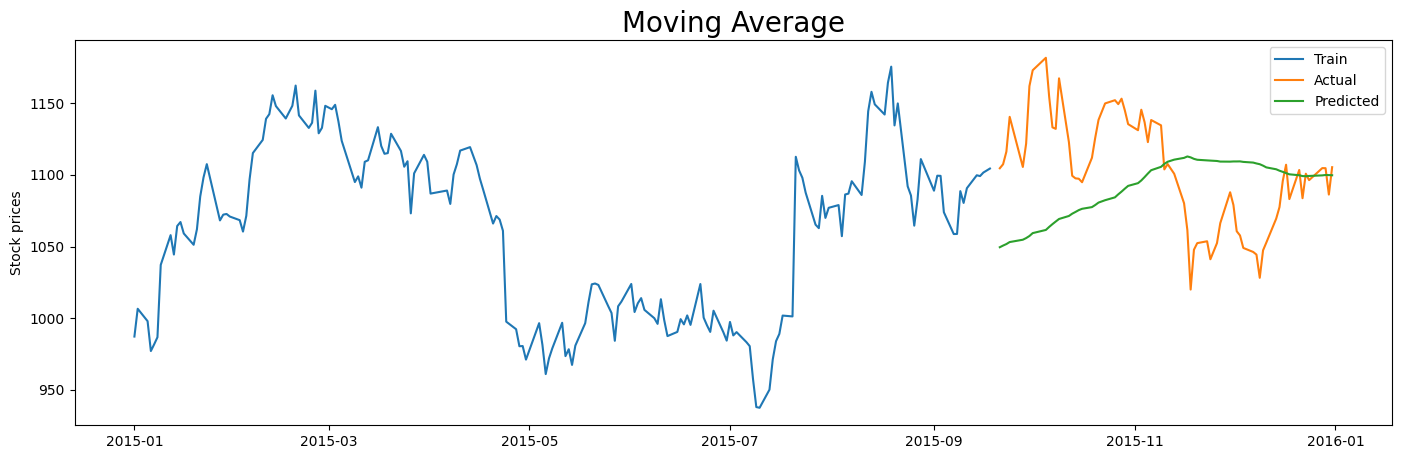

In [75]:
plot_pred(y_ma,"Moving Average")

4. **Weighted Moving Average**

We will obtain the stock price on the test date by calculating the weighted mean of past 80 days. The last of the 80 day will have a weightage of 1(=80/80) and the first will have a weightage of 1/80.

In [76]:
weight = np.array(range(1,81))/80
#weighted moving average
y_wma = X_test@weight/sum(weight)
mse(y_wma,y_test),np.sqrt(mse(y_wma,y_test))

(1769.4332039308204, np.float64(42.064631270591455))

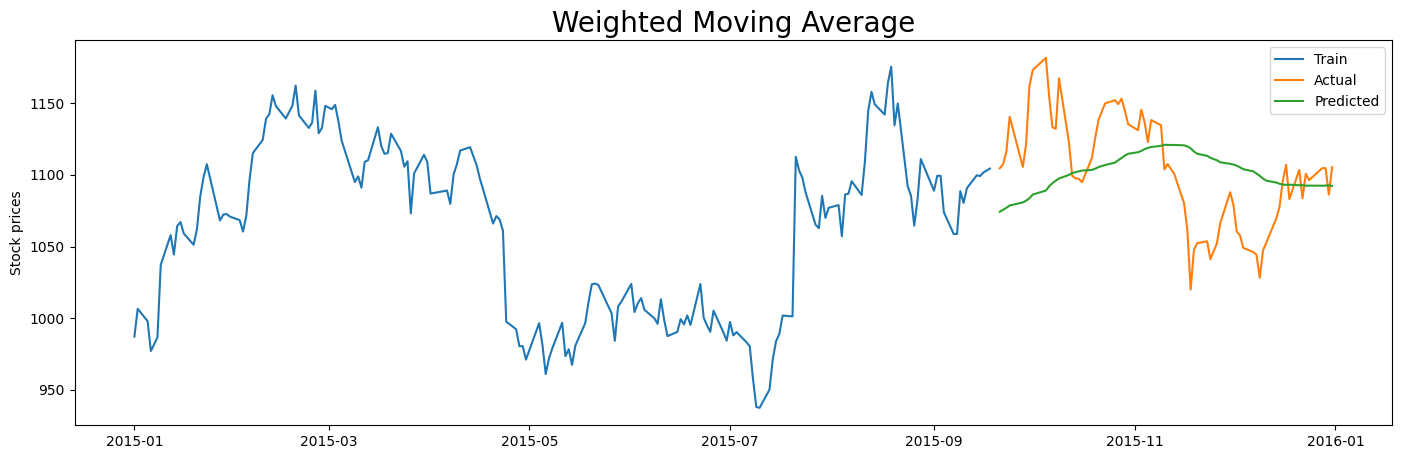

In [77]:
plot_pred(y_wma,"Weighted Moving Average")

4. **Linear regression**

In this method, we will perform a linear regression on our dataset. The values will be predicted as a linear combination of the previous 80 days values.

In [78]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()

lr.fit(X_train,y_train) # Training the models
y_lr = lr.predict(X_test) # inference
y_lr = pd.Series(y_lr,index=y_test.index)

mse(y_test,y_lr), np.sqrt(mse(y_test,y_lr))

(1754.1645412925657, np.float64(41.88274753753108))

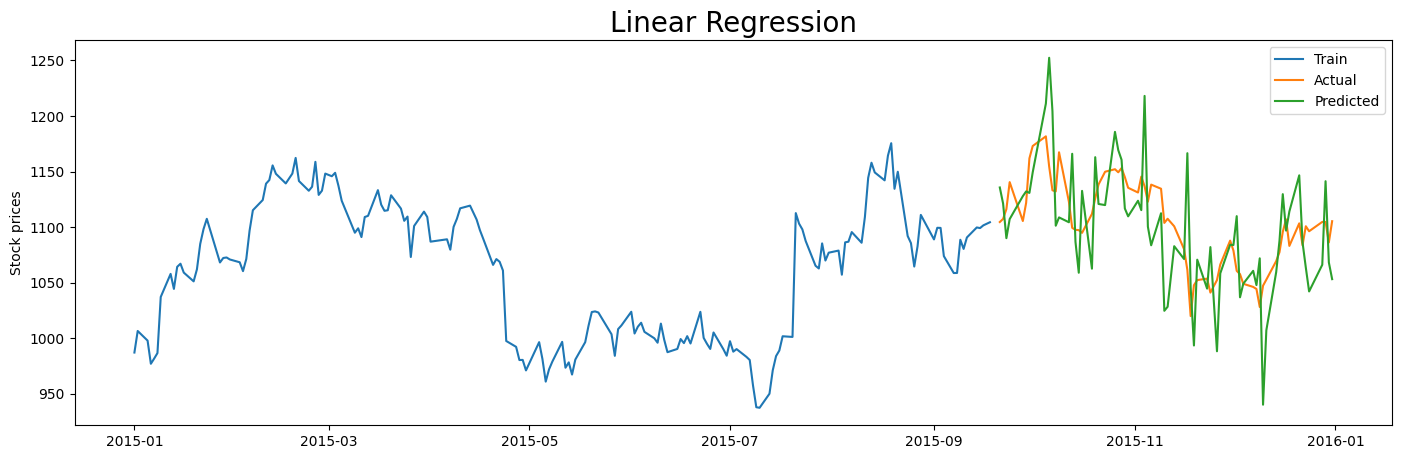

In [79]:
plot_pred(y_lr,"Linear Regression")

6. **Weighted Linear Regression**

We will provide weightage to our input data rather than the features.

In [80]:
weight = np.array(range(1,101))/100
wlr = LinearRegression()

wlr.fit(X_train,y_train,weight)
y_wlr = wlr.predict(X_test)
y_wlr = pd.Series(y_wlr,index=y_test.index)

mse(y_test,y_wlr), np.sqrt(mse(y_test,y_wlr))

(2054.361407878746, np.float64(45.325063793432726))

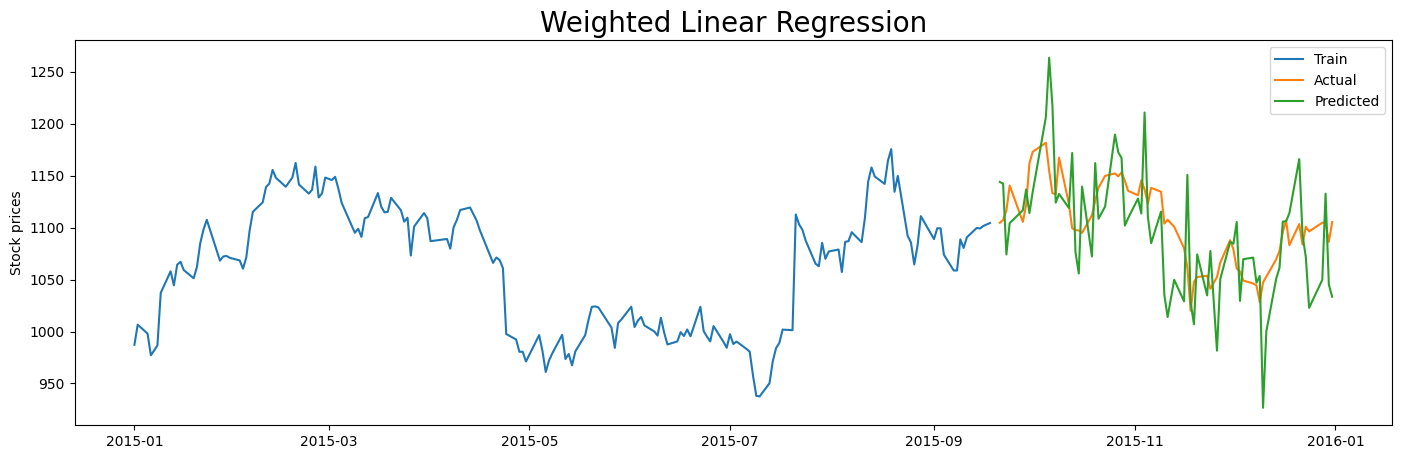

In [81]:
plot_pred(y_wlr,"Weighted Linear Regression")

7. **Lasso Regression**

Linear Regression with L1 regulations.

In [82]:
from sklearn.linear_model import Lasso
lasso = Lasso()

las = lasso.fit(X_train,y_train)
y_las = las.predict(X_test)
y_las = pd.Series(y_las,index = y_test.index)

mse(y_las,y_test), np.sqrt(mse(y_test,y_wlr))

C:\Users\PAVPA\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.020e+02, tolerance: 3.391e+01
  model = cd_fast.enet_coordinate_descent(


(1467.333864613377, np.float64(45.325063793432726))

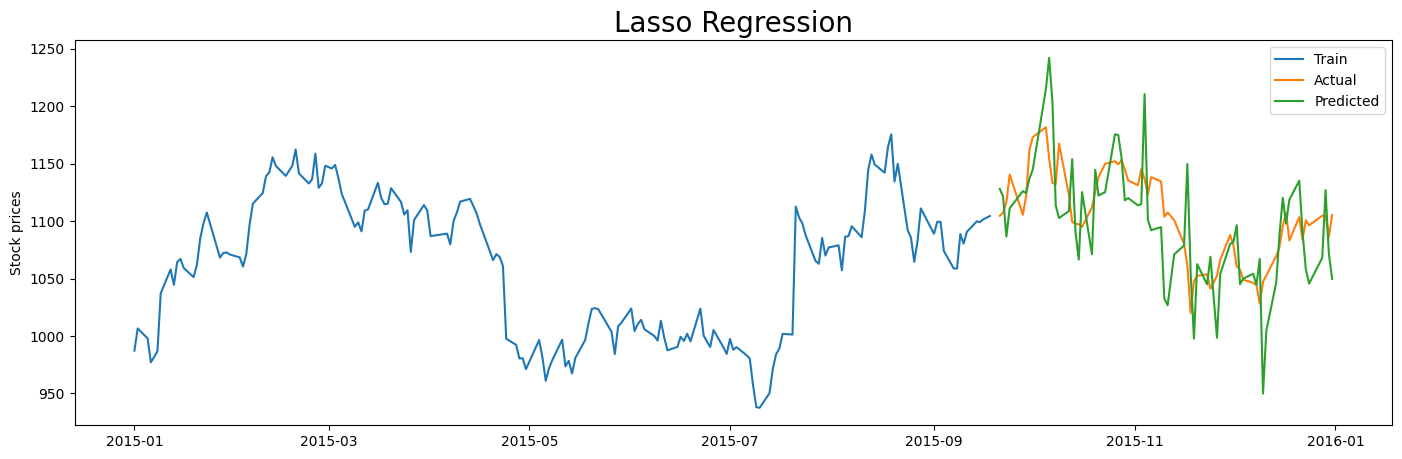

In [83]:
plot_pred(y_las,"Lasso Regression")

8. **Moving window Neural Network**

We construct a simple Feed Forward network taking 80 features as our input.

In [85]:
from keras.models import Sequential
from keras.layers import Dense

#moving average Neural Network
ma_nn = Sequential([Dense(64,input_shape=(80,),activation='relu'),
                    Dense(32,activation='linear'),Dense(1)])

ma_nn.compile(loss='mse',optimizer='rmsprop',metrics=['mae','mse'])

history = ma_nn.fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.25)

ModuleNotFoundError: No module named 'tensorflow'

In [86]:
plt.plot(history.history['mse'],label='Training loss')
plt.plot(history.history['val_mse'], label='Validation loss')
plt.title("Mean Squared error")
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
loss_nn,mae_nn,mse_nn = ma_nn.evaluate(X_test,y_test)
print("\nloss:",loss_nn,"\nmae:",mae_nn,"\nmse:",mse_nn)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1692.2251 - mae: 32.1351 - mse: 1692.2251

loss: 1922.77734375 
mae: 34.27025604248047 
mse: 1922.77734375


In [ ]:
y_nn = ma_nn.predict(X_test)
y_nn = pd.Series(y_nn[:,0],index=y_test.index)
mse(y_nn,y_test),np.sqrt(mse(y_nn,y_test))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


(1922.7772800733499, 43.849484376368096)

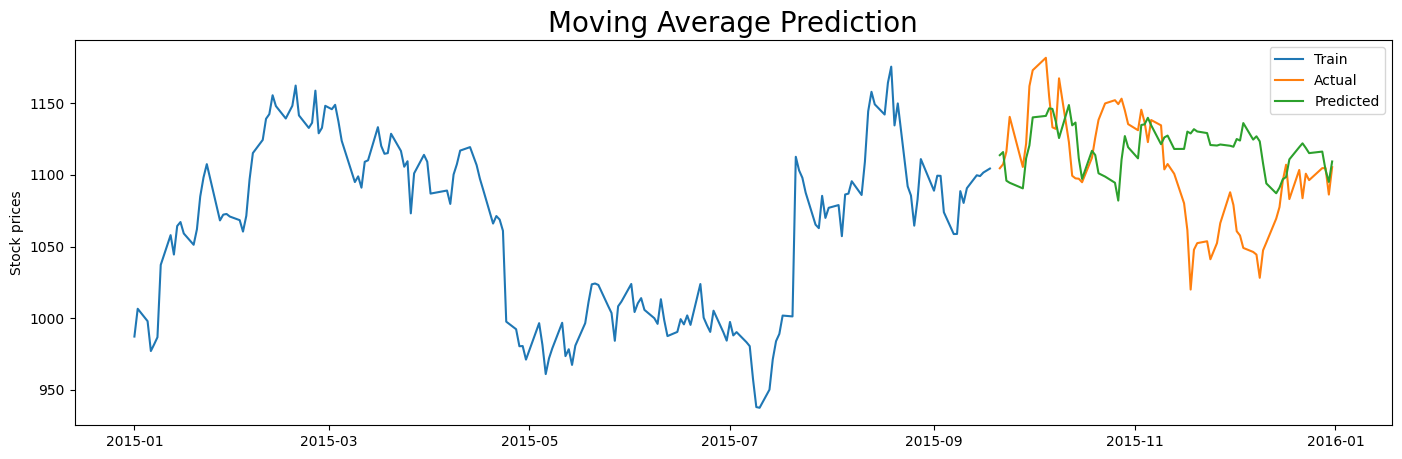

In [ ]:
plot_pred(y_nn,"Moving Average Prediction")